# Analyze contact interactions of Hv1-2GBI system.

By: Victoria Lim  
Last updated: 2018-02-22

This notebook processes the pickled pandas dataframe of contact interactions from node-edge interactions processed in VMD.  
Pickle file details:
- Generated from: `/beegfs/DATA/mobley/limvt/hv1/04_fep/postFEPvanilla/analysis/3_nonCovInts/nodeContacts.py`
- Pickle dump line: `pickle.dump((nodes, edges), open( pickleOut, "wb" ) )`

**Notebook inputs**:  
Nodes and edges are pandas dataframes as generated in the above script.
- Node example:
  - TODO

- Node details:
  - TODO



- Edge example:

||node_i | node_j | weight | attribute | count | average |
------------------------------------------------------- |
|34647 |	165 | 174 |	132 |	HPHOB | 97.0 | 1.360825 |
|34648 |	165	| 175 | 322 |	HPHOB | 130.0 | 2.476923 |

- Edge details:
  - First column is the pandas dataframe index. This value is not significant.
  - `node_i`: TODO -- include notes from README and reference for Benson&Daggett
  - `node_j`: The node interacting with `node_i`. The value of `node_j` should always be greater than or equal to that of `node_i`.
  - `weight`: Each node has a variable number of atoms. The weight of an interaction is the number of interactions for the atoms in `node_i` to the atoms in `node_j`. The weight listed is the sum over all frames of the weights found for this node pair.
  - `attribute`
  - `count`: Number of trajectory frames this edge interaction was found.
  - `average`: This is taken as the quotient of `weight`/`count`.

**Troubleshooting**:
* If you subtract two edge dataframes and lose most interactions, it might be that the node indices don't match up.   
  * For example, let's say dataframe_1 has the node_35 to node_99 interaction as an HBOND,  
but dataframe_2 shows the node_35 to node_99 interaction as COUL (Coulombic) interaction.  
There was a mutation associated with dataframe_2, which knocked out 5 nodes, starting at node_80.  
Then the real match of dataframe_1's node_35 to node_99 for dataframe_2 is with node_35 to node_94.  
  * This _shouldn't_ be an issue since the `diffEdges` function should take out any edge involving  
any mutation-related notes, and then scale the rest of the edges by that offset.  
(By the way, this function does have a pretty limited use-case currently, so check the documentation.)
  * To determine if this is the case, look for the line:  
`diff_edges_x = noMut_edges_x.merge(noMut_edges_y,on=['node_i','node_j','attribute'],how='inner')`  
(or the analogus merge line), and take out the requirement to match on attribute as well as on nodes:  
`diff_edges_x = noMut_edges_x.merge(noMut_edges_y,on=['node_i','node_j',],how='inner')`.  
Print and scrutinize the resulting edges dataframe, such as using `head()`, `tail()` or `iloc[range1:range2]`.

* If you `.apply` some function to a pandas dataframe column and get some error:  
Try iterating over the column and applying that function one-by-one to look for the bug.  
`for i, (index, row) in enumerate(diff_edges_1.iterrows()):`

* If you see `SettingWithCopyWarning`, it's probably because you're altering some dataframe that's likely a copy of the original. That might be fine if you have just one change to make (e.g., I was able to increment all of `node_i`). However, if you have to work with it further, then consider wrangling with `.loc` (or similar) functions for modifying the bona fide dataframe (e.g., when I then tried to increment `node_j`, the original changes to `node_i` were gone).

**References**:
TODO

**Questions to self**:
* For a heat map of edge differences, such as before and after mutation, what cutoff is significant? Do you notice in the trajectory, for example, when the data says the interaction between F150 and 2GBI:benzo decreases by '-5'?

___________________________________________________________________


**TODO for R211S**:
* interactions of d112 d185 (before and after) (waters?)


**TODO**: 
* subtract edges for 2GBI taut2 and taut1 by connecting benzo--benzo, guan--guan, CNN--(NN+CN)
* make WATERS general enough to see which residues have most overall contact with any water?
* write documentation
* make the heatplot a 3D plot colored by inttype (e.g., COUL)
* is it valid to subtract edge data when the averages may have come from different-length trajectories?



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns # heatmap with pandas

#%matplotlib inline
#%matplotlib notebook
np.__file__

'/home/limvt/local/lib/anaconda3/lib/python3.6/site-packages/numpy/__init__.py'

In [2]:
def getEdgePair(node1, node2, edges):
    """
    
    Notes
    -----
    Can't find the interaction you're looking for? Might need to
    add/subtract an offset if you used the diffEdges function. 
    The offset value (with sign and magnitude) should have been
    printed out: "Shifting node indices by..."
    
    """
    return edges[(edges.node_i == node1) & (edges.node_j == node2)]

def findInEdges(nodeNum, edges, att=None):
    """
    """
    if att is not None:
        return edges[(edges.attribute == att) & ((edges.node_i == nodeNum) | (edges.node_j == nodeNum))]
    else:
        return edges[(edges.node_i == nodeNum) | (edges.node_j == nodeNum)]
    

def getResidInfo(resid, nodes, resExcludes=[]):
    """
    Get the node information for specified protein residue index.
    
    Parameters
    ----------
    nodes: pandas dataframe of nodes
    resid: integer value of the protein residue index
    resExcludes: list of strings, for each residues to ignore.
                 e.g., ['WAT']
    Returns
    -------
    nodes_id: pandas dataframe with only residue of interest
    
    """
    nodes_id = nodes.loc[nodes['resid'] == resid]
    nodes_id = nodes_id[~nodes_id.resname.isin(resExcludes)]

    return nodes_id



def idxToResid(idx, nodes, idOnly=False):
    """
    This function takes in some node index and generates 
    a string code of one-letter residue name and integer of residue number.
    
    Parameters
    ----------
    idx    | int       | integer index of the pandas dataframe
    nodes  | pandas df | pandas dataframe of which to search
    idOnly | Bool      | specify True to return numpy.int64 of residue number
                         specify False to return code with resname abbrev
                         ex., True returns 150; False returns 'F150:sc'
    Returns
    -------
    code - string or numpy.int64 value of residue. (see idOnly parameter)
    
    """
    aa_dict = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'HSD': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M',
     'GBI1':'GBI1', 'GBI2':'GBI2', 'WAT':'WAT'}
    
    #old way not conducive to taking diff of dataframes
    #entry = nodes.iloc[idx-1]
    entry = nodes.loc[nodes.index == idx] # iloc gives series, loc gives dataframe
    entry = entry.T.squeeze() # convert from dataframe to series
    resname = entry['resname']
    if resname in ['GBI1','GBI2']:
        code = aa_dict[resname]+':'+entry['code']
    elif resname == 'WAT':
        code = aa_dict[resname]+str(entry['resid'])
    else: # if not GBI or WAT, must be Hv1
        if idOnly: code = entry['resid']
        else: code = aa_dict[resname]+str(entry['resid'])+':'+entry['location']       

    return code

In [24]:
def prioritizeOrPivot(edges, prioritize=True, rawNum=None):
    """
    Pull out N strongest interactions, or pivot the table.
    Not meant for user; implemented in protLigInts and selectionInts functions.
    """
    if prioritize:
        if rawNum is None:
            print("ERROR: rawNum variable was not passed into prioritizeOrPivot function")
            return None
        try: # Pull out the N strongest interactions (should be no negative values)
            edges = edges.sort_values('average',ascending=False).head(rawNum)
        except KeyError: # if no 'average' column then this is one df minus another so there are negatives
            # sort by magnitude to get + and - changes
            tempinds = edges.avg_subt.abs().sort_values(ascending=False).head(rawNum).index
            edges = edges.loc[tempinds]
        return edges
    
    else: # pivot table for plotting
        try:
            edges = edges.pivot(index='node_i',columns='node_j', values='average')
        except KeyError:
            edges = edges.pivot(index='node_i',columns='node_j', values='avg_subt')
        edges = edges.dropna(axis=1,how='all') # drop columns with all nan's
        return edges

def protLigInts(nodes, edges, rawNum=250):
    """
    Take in a set of nodes and edges and identify the N strongest interactions.
    This function disregards:
      (1) interactions between waters (there can be protein-water interaction),
      (2) interactions between adjacent residues (e.g., residue F149 and F150), and
      (3) interactions within the same residue (e.g., backbone and sidechain of F150).
      
    Parameters
    ----------
    nodes | pandas df | pandas dataframe with information on nodes (residues)
    edges | pandas df | pandas dataframe with information on edges (contacts)
    rawNum  | int       | How many interactions to use before further processing. 
                          Further processing = remove adjacent & intra-residue interactions.
                          May want to increase this parameter if no GBI interactions show up.
    Returns
    -------
    watless_edges - pandas dataframe with reduced and filtered interactions
    
    """
    # Get all indices of nodes that are not water
    watless_idx = nodes.index[nodes['resname'] != 'WAT'].tolist()
    # Get edge interactions that involve no waters
    watless_edges = edges.loc[edges['node_i'].isin(watless_idx) | edges['node_j'].isin(watless_idx)]
    
    # Pull out the N strongest interactions
    watless_edges = prioritizeOrPivot(watless_edges,prioritize=True,rawNum=rawNum)
    if watless_edges is None: return
    
    # Make temp copy to compare protein resIDs to ignore those in same/adj resid
    temp = watless_edges.copy()
    temp['node_i'] = temp['node_i'].apply(idxToResid,args=(nodes,True))
    temp['node_j'] = temp['node_j'].apply(idxToResid,args=(nodes,True))
    # convert the non-protein residues with no ID for temp integer
    temp['node_i'].replace('GBI\w', -500, regex=True,inplace=True)
    temp['node_j'].replace('GBI\w', -500, regex=True,inplace=True)
    temp['node_i'].replace('WAT\w', -400, regex=True,inplace=True)
    temp['node_j'].replace('WAT\w', -400, regex=True,inplace=True)
    
    # drop node interactions in same resid or adjacent
    dropinds = temp.index[((temp['node_i']-temp['node_j']).abs() <= 1) == True].tolist()
    watless_edges.drop(dropinds, inplace=True)

    # pivot table for plotting
    watless_edges = prioritizeOrPivot(watless_edges,prioritize=False)

    return watless_edges

    
def selectionInts(nodes, edges, indices, rawNum=50):
    """
    indices: pandas dataframe of node indices for interaction analysis of this selection
    
    Examples of selecting indices
    -----------------------------
    > gidx_1 = nodes_1.index[nodes_1['resname'] == 'GBI1'].tolist()
    
    > selNodes = getResidInfo(211, nodes_2, resExcludes=['WAT'])
    > selInds = selNodes.index.tolist()
    
    """

    # Get all the edge interactions that relate to selection
    sel_edges = edges.loc[edges_1['node_i'].isin(indices) | edges['node_j'].isin(indices)]
    
    # Pull out the N strongest interactions
    sel_edges = prioritizeOrPivot(sel_edges,prioritize=True,rawNum=rawNum)
    if sel_edges is None: return
    
    # put all the GBI nodes in the i spot
    sel_edges["node_i"], sel_edges["node_j"] = np.where(sel_edges['node_j'].isin(indices), 
        [sel_edges["node_j"], sel_edges["node_i"]], [sel_edges["node_i"], sel_edges["node_j"]])
    # OPTIONAL -- remove j nodes with GBI or WAT (i.e., remove interactions with self and with water)
    sel_edges = sel_edges[~sel_edges['node_j'].isin(indices)] # remove self-interactions
    watidx = nodes.index[nodes['resname'] == 'WAT'].tolist() # get water indices
    sel_edges = sel_edges[~sel_edges['node_j'].isin(watidx)] # remove water interactions

    # pivot table for plotting
    sel_edges = prioritizeOrPivot(sel_edges,prioritize=False)
    
    return sel_edges


def plotHeatInts(nodes,edges,minHeat=0,maxHeat=20,colors=None,size=(20,20),seltitle=""):
    """
    
    maxHeat | int  | Maximum data point in heat color bar.
                     May want to manually adjust if max edge data > default maxHeat.
    """
    def offsetHeatGrid():
        # offset the y-grid to match the label WITHOUT offsetting ticklabels
        yticks_old = ax.get_yticks()
        if len(yticks_old) > 1:
            yticks_offset = (yticks_old[1]-yticks_old[0])/2
            yticks = [(tick-yticks_offset) for tick in ax.get_yticks()]
            ax.set_yticks(yticks) # grid will use these new tick placements
            ax.set_yticks(yticks_old,minor=True)
            ax.set_yticklabels(ylabels,minor=True) # put labels back in old placements
            ax.set_yticklabels([]) # turn off labels at new tick placements

        # offset the x-grid to match the label WITHOUT offsetting ticklabels
        xticks_old = ax.get_xticks()
        if len(xticks_old) > 1:
            xticks_offset = (xticks_old[1]-xticks_old[0])/2
            xticks = [(tick-xticks_offset) for tick in ax.get_xticks()]
            ax.set_xticks(xticks) # grid will use these new tick placements
            ax.set_xticks(xticks_old,minor=True)
            ax.set_xticklabels(xlabels,minor=True) # put labels back in old placements
            ax.set_xticklabels([]) # turn off labels at new tick placements
        
    plotInput = edges
    plotNodes = nodes
    
    # generate plot labels based on residue name and residue number
    ylabels = [idxToResid(i, plotNodes) for i in list(plotInput)] # get node_j's, convert idxToResid
    xlabels = [idxToResid(i, plotNodes) for i in list(plotInput.index.values)] # get node_i's, convert idxToResid

    # plot the data
    plt.clf()
    plt.subplots(figsize=size)
    sns.set(font_scale=2.1)
    ax = sns.heatmap(plotInput.T,annot=True,yticklabels=ylabels,xticklabels=xlabels,
                     cmap=colors,vmin=minHeat, vmax=maxHeat)
    
    offsetHeatGrid()

    plt.grid()
    plt.ylabel('')
    plt.xlabel('')
    plt.yticks(rotation=0)
    plt.title('\"Strongest\" interactions of {}'.format(seltitle))
    plt.show()
    print('interaction range is from {} to {}; verify if this is appropriate'.format(minHeat,maxHeat))
    

In [4]:
def diffEdges(nodes_x,nodes_y,edges_x,edges_y):
    """
    USE CASES: 
       [1] taut1 and taut2 with same protein system but differs in 2GBI and maybe in waters
       [2] tautx before and after mutation, all else the same (same 2GBI and waters)

    """
    # get nodes in common between both dataframes but keep nodes_y indices, https://tinyurl.com/y9qwemhv
    nodes_unified = nodes_y.reset_index().merge(nodes_x, how='inner', on=['resname','resid','location','type','code','nAtoms']).set_index('index')
    # take union of both dataframes wrt to nodes_y, and ...
    df_1 = pd.merge(nodes_y, nodes_x, how='outer', indicator=True)
    # do again to get orig indices of nodes_x, ...
    df_2 = pd.merge(nodes_x, nodes_y, how='outer', indicator=True)
    # in order to find rows not in one or other
    rows_in_df1_not_in_df2 = df_1[df_1['_merge']=='left_only'][nodes_y.columns]
    rows_in_df2_not_in_df1 = df_2[df_2['_merge']=='left_only'][nodes_x.columns]
    # convert those rows to list of indices
    nodes_in_df1_not_in_df2 = rows_in_df1_not_in_df2.index.tolist()
    nodes_in_df2_not_in_df1 = rows_in_df2_not_in_df1.index.tolist()
    print("nodes in 1st, not in 2nd: ",nodes_in_df1_not_in_df2)
    print("nodes in 2nd, not in 1st: ",nodes_in_df2_not_in_df1)
    
    # remove the those indices from each set of edges respectively
    noMut_edges_y = edges_y.loc[~edges_y['node_i'].isin(nodes_in_df1_not_in_df2)]
    noMut_edges_y = noMut_edges_y.loc[~noMut_edges_y['node_j'].isin(nodes_in_df1_not_in_df2)]
    noMut_edges_x = edges_x.loc[~edges_x['node_i'].isin(nodes_in_df2_not_in_df1)]
    noMut_edges_x = noMut_edges_x.loc[~noMut_edges_x['node_j'].isin(nodes_in_df2_not_in_df1)]
    
    
    # scale edges_x to match indices of nodes_y
    mut1_start = nodes_in_df1_not_in_df2[0]
    mut2_start = nodes_in_df2_not_in_df1[0]
    if not mut1_start == mut2_start:
        print("ERROR: start node value of mutation(?) do not match between nodes_y and nodes_x")
        exit()
    mut1_end = nodes_in_df1_not_in_df2[-1]
    mut2_end = nodes_in_df2_not_in_df1[-1]
    offset = mut1_end - mut2_end # this is not valid if there are 2 sets of changes (e.g., mutation && taut)
    mask_i = (noMut_edges_x['node_i'] > mut2_end)
    mask_j = (noMut_edges_x['node_j'] > mut2_end)
    to_change_i = noMut_edges_x[mask_i]
    to_change_j = noMut_edges_x[mask_j]
    
    print("Shifting node indices by {} for {} rows".format(offset,len(to_change_i.index)+len(to_change_j.index)))
    to_change_i['node_i'] += offset
    to_change_j['node_j'] += offset
    new_nodes_i = to_change_i.pop('node_i')
    new_nodes_j = to_change_j.pop('node_j')
    noMut_edges_x.loc[noMut_edges_x.index.isin(to_change_i.index), 'node_i'] = new_nodes_i
    noMut_edges_x.loc[noMut_edges_x.index.isin(to_change_j.index), 'node_j'] = new_nodes_j
    
    # subtract the set of edges based on matching nodes (x-y)
    diff_edges_x = noMut_edges_x.merge(noMut_edges_y,on=['node_i','node_j','attribute'],how='inner')
    diff_edges_x['avg_subt'] = diff_edges_x['average_x']-diff_edges_x['average_y']
    
    return nodes_unified, diff_edges_x

## Load in data

In [5]:
#nodes_r, edges_r = pickle.load( open( 't0_s211.pickle', "rb" ))
nodes_0, edges_0 = pickle.load( open( 't0_s211.pickle', "rb" ))
nodes_1, edges_1 = pickle.load( open( 't1_s211.pickle', "rb" ))
nodes_2, edges_2 = pickle.load( open( 't2_s211.pickle', "rb" ))

In [6]:
wt_nodes_0, wt_edges_0 = pickle.load( open( 't0_wt.pickle', "rb" ))
wt_nodes_1, wt_edges_1 = pickle.load( open( 't1_wt.pickle', "rb" ))
wt_nodes_2, wt_edges_2 = pickle.load( open( 't2_wt.pickle', "rb" ))

In [7]:
nodes_1.loc[nodes_1['resname'] == 'GBI1']

,resname,resid,location,type,code,nAtoms
index,,,,,,
11230,GBI1,230,lg,NOP,BENZ,6
11231,GBI1,230,lg,DIP,NN,1
11232,GBI1,230,lg,DIP,CN,2
11233,GBI1,230,lg,POS,GUAN,4


In [8]:
nodes_2.loc[nodes_2['resname'] == 'GBI2']

,resname,resid,location,type,code,nAtoms
index,,,,,,
11227,GBI2,230,lg,NOP,BENZ,6
11228,GBI2,230,lg,POS,CNN,3
11229,GBI2,230,lg,DIP,GUAN,4


### Demonstrate some functions defined in this notebook

In [9]:
findInEdges(413, wt_edges_1,'STER')

,node_i,node_j,weight,attribute,count,average
80287,402,413,135,STER,115.0,1.173913
80693,405,413,381,STER,250.0,1.524000
80751,408,413,2490,STER,250.0,9.960000
80844,410,413,1250,STER,250.0,5.000000
81290,411,413,1535,STER,250.0,6.140000
82683,413,414,902,STER,250.0,3.608000


In [10]:
idxToResid(191, nodes_1,idOnly=False)

'F150:sc'

In [11]:
getResidInfo(211, nodes_2)

,resname,resid,location,type,code,nAtoms
index,,,,,,
381,SER,211,sc,NOP,AB,2
382,SER,211,sc,DIP,G,1
383,SER,211,bb,DIP,BB,3
657,WAT,211,wt,DIP,OH2,1


In [12]:
getResidInfo(211, nodes_2, resExcludes=['WAT'])

,resname,resid,location,type,code,nAtoms
index,,,,,,
381,SER,211,sc,NOP,AB,2
382,SER,211,sc,DIP,G,1
383,SER,211,bb,DIP,BB,3


In [13]:
getEdgePair(413,420,wt_edges_1)

,node_i,node_j,weight,attribute,count,average
82688,413,420,7,HBOND,7.0,1.0


## Analysis 1: protein+ligand interactions

NOTE: Right now, I'm not sure how to interpret these heat maps well or how to make them more useful.

In [ ]:
# taut2
watless_edges_2 = protLigInts(nodes_2, edges_2)
plotHeatInts(nodes_2,watless_edges_2,minHeat=0,maxHeat=20,colors="YlGn")

In [ ]:
# taut1
watless_edges_1 = protLigInts(nodes_1, edges_1)
plotHeatInts(nodes_1,watless_edges_1,minHeat=0,maxHeat=20,colors="YlGn")

## Analysis 2: protein+ligand interactions, with reference to taut1

nodes in 1st, not in 2nd:  [11226, 11227, 11228, 11229, 11230, 11231, 11232]
nodes in 2nd, not in 1st:  [11226, 11227, 11228]
Shifting node indices by 4 for 150 rows


/home/limvt/local/lib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


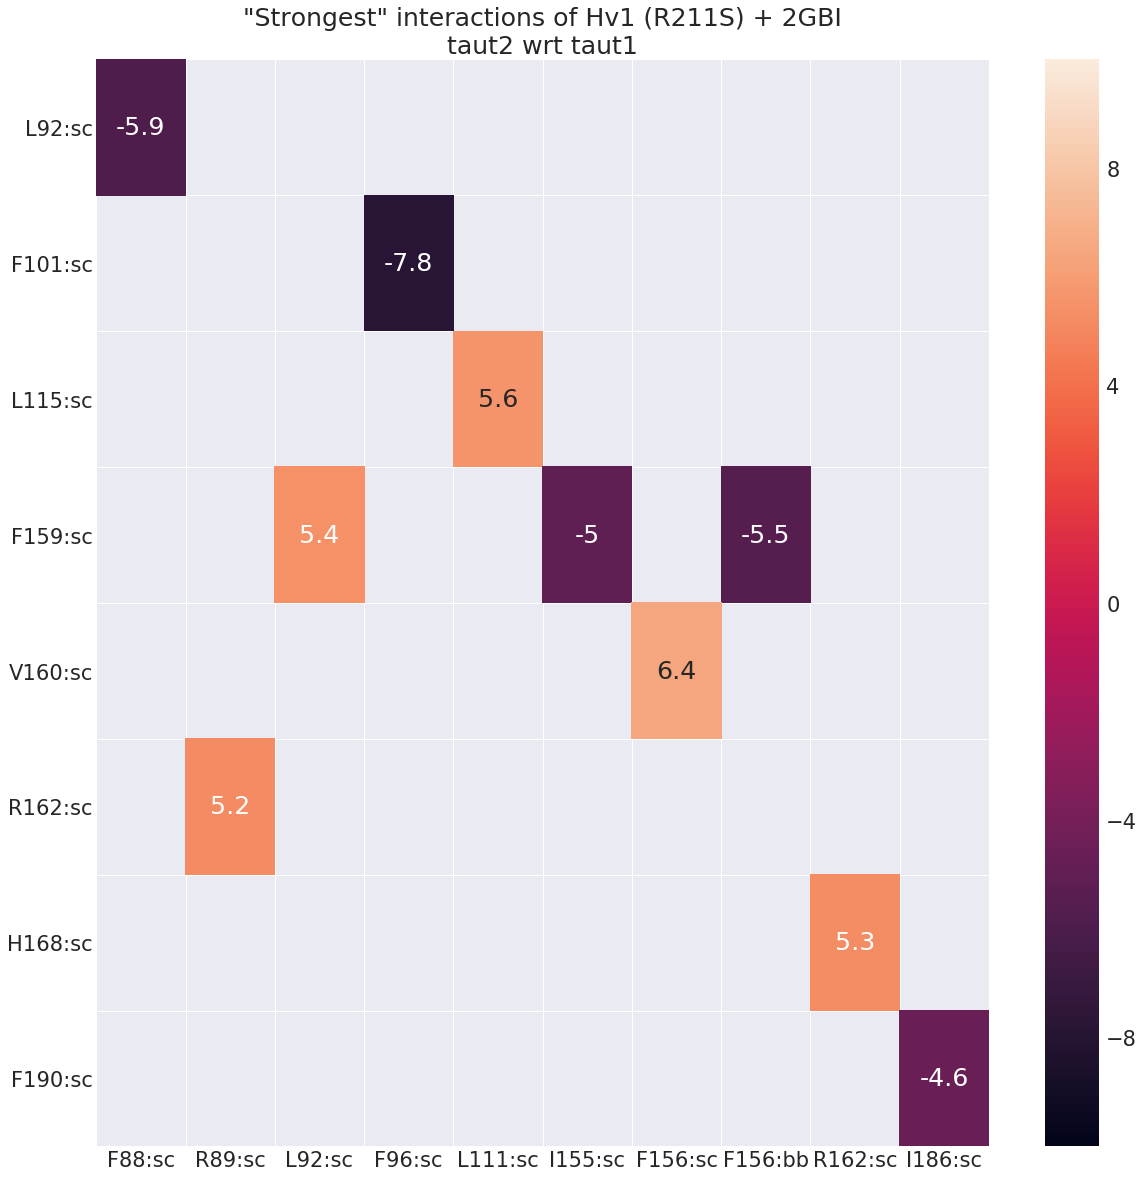

interaction range is from -10 to 10; verify if this is appropriate


In [16]:
diff_nodes_21, diff_edges_21 = diffEdges(nodes_2,nodes_1,edges_2,edges_1)
watless_diff_edges_21 = protLigInts(diff_nodes_21, diff_edges_21,rawNum=25) # make sure you use REFERENCE nodes
plotHeatInts(diff_nodes_21, watless_diff_edges_21, minHeat=-10, maxHeat=10, seltitle="Hv1 (R211S) + 2GBI\ntaut2 wrt taut1")

nodes in 1st, not in 2nd:  [11229, 11230, 11231, 11232]
nodes in 2nd, not in 1st:  [11229, 11230, 11231, 11232]
Shifting node indices by 0 for 0 rows


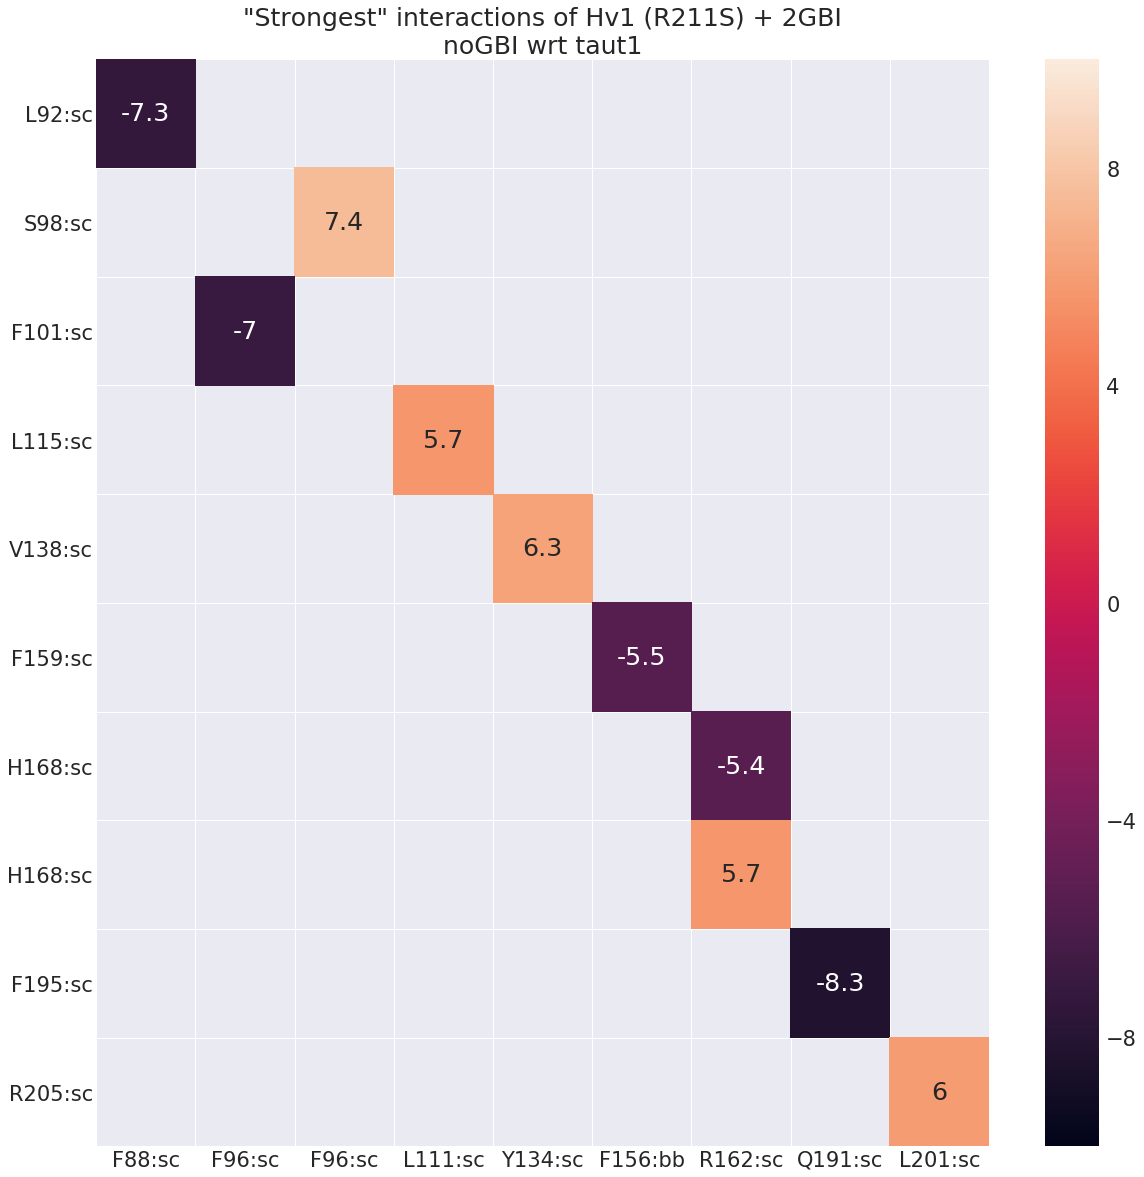

interaction range is from -10 to 10; verify if this is appropriate


In [17]:
diff_nodes_01, diff_edges_01 = diffEdges(nodes_0,nodes_1,edges_0,edges_1)
watless_diff_edges_01 = protLigInts(diff_nodes_01, diff_edges_01,rawNum=25) # make sure you use REFERENCE nodes
plotHeatInts(diff_nodes_01, watless_diff_edges_01, minHeat=-10, maxHeat=10, seltitle="Hv1 (R211S) + 2GBI\nnoGBI wrt taut1")

## Analysis 3: protein+ligand interactions, comparing before/after mutation

nodes in 1st, not in 2nd:  [380, 381, 382, 383]
nodes in 2nd, not in 1st:  [380, 381, 382]
Shifting node indices by 1 for 826669 rows


/home/limvt/local/lib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/limvt/local/lib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


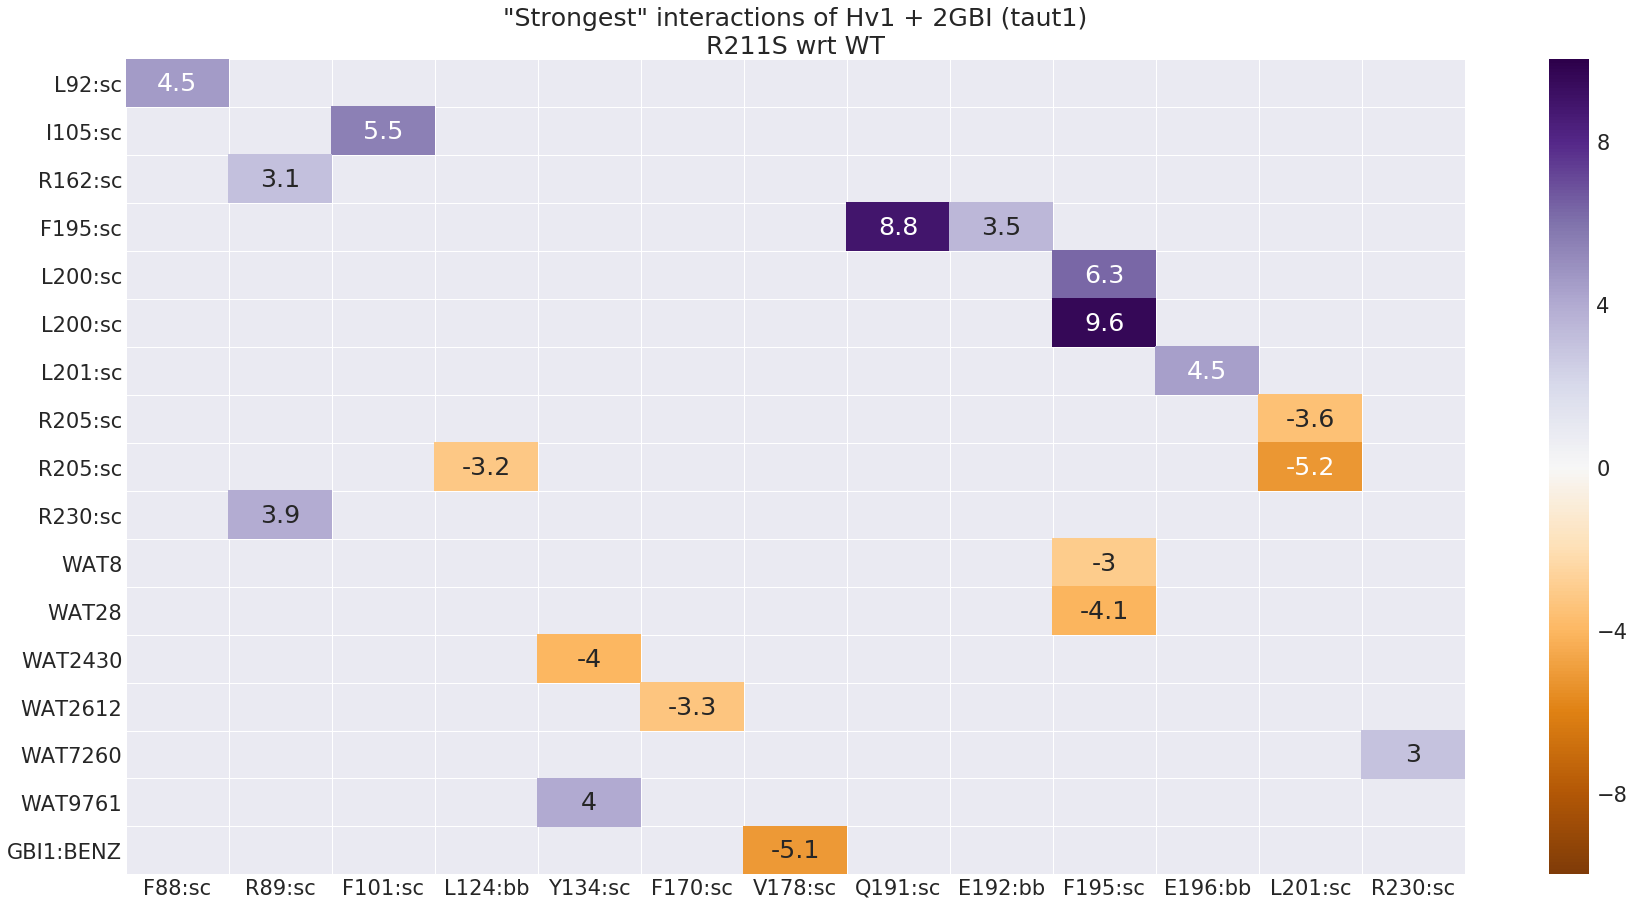

interaction range is from -10 to 10; verify if this is appropriate


In [18]:
diff_nodes_1, diff_edges_1 = diffEdges(nodes_1,wt_nodes_1,edges_1,wt_edges_1)
watless_diff_edges_1 = protLigInts(diff_nodes_1, diff_edges_1,rawNum=25) # make sure you use REFERENCE nodes
plotHeatInts(diff_nodes_1, watless_diff_edges_1, minHeat=-10, maxHeat=10,colors='PuOr',size=(30,15),seltitle="Hv1 + 2GBI (taut1)\nR211S wrt WT")

nodes in 1st, not in 2nd:  [380, 381, 382, 383]
nodes in 2nd, not in 1st:  [380, 381, 382]
Shifting node indices by 1 for 809366 rows


/home/limvt/local/lib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/limvt/local/lib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


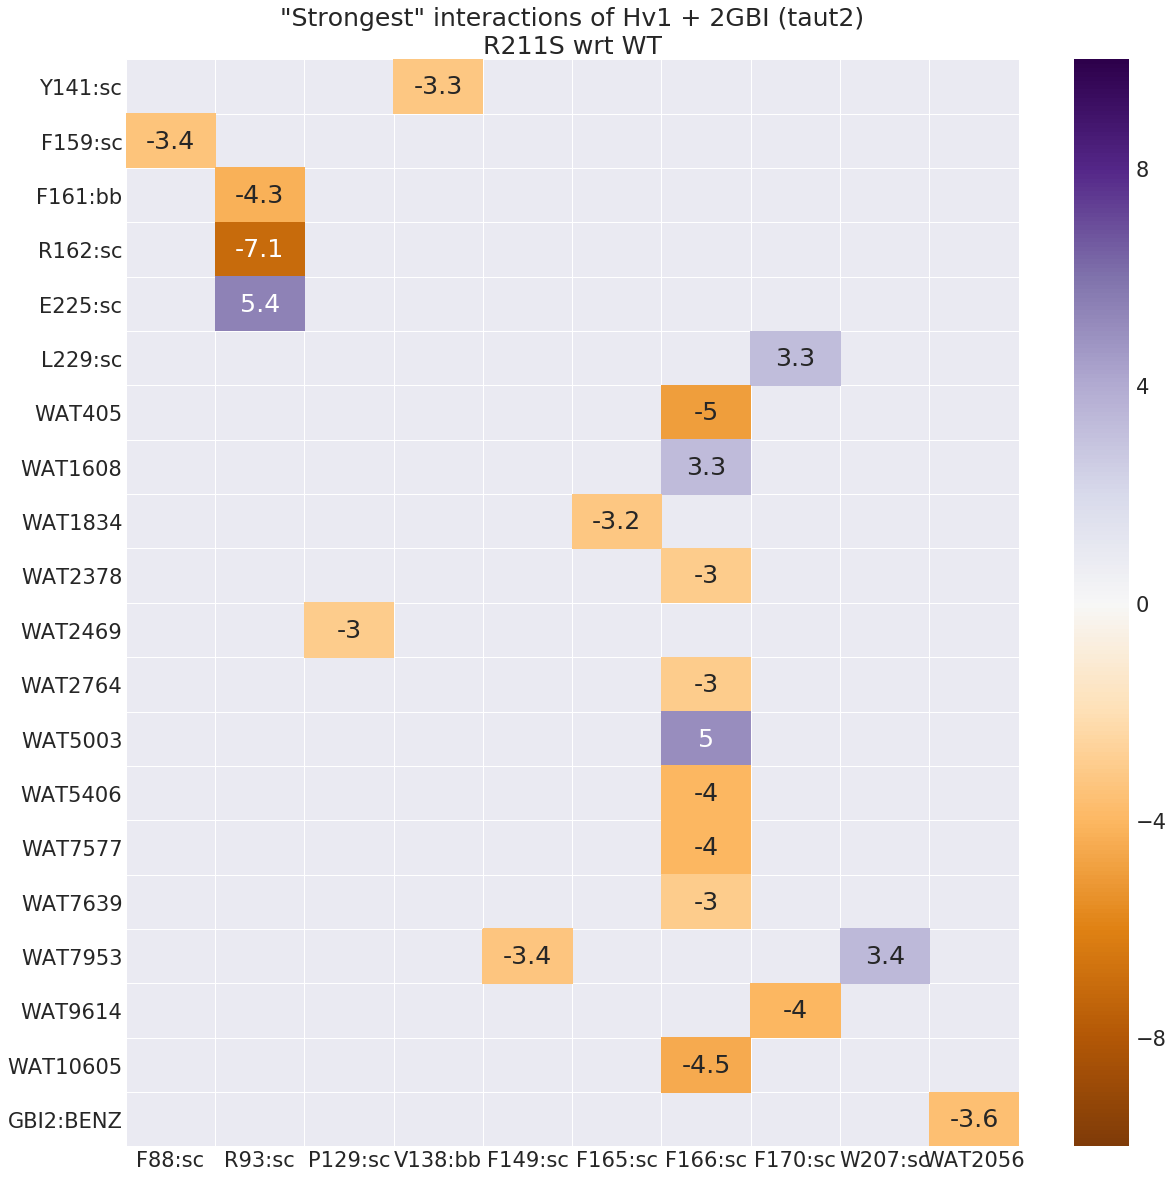

interaction range is from -10 to 10; verify if this is appropriate


In [19]:
diff_nodes_2, diff_edges_2 = diffEdges(nodes_2,wt_nodes_2,edges_2,wt_edges_2)
watless_diff_edges_2 = protLigInts(diff_nodes_2, diff_edges_2,rawNum=25) # make sure you use REFERENCE nodes
plotHeatInts(diff_nodes_2, watless_diff_edges_2, minHeat=-10, maxHeat=10,colors='PuOr',seltitle="Hv1 + 2GBI (taut2)\nR211S wrt WT")

## Analysis 4: 2GBI-specific interactions

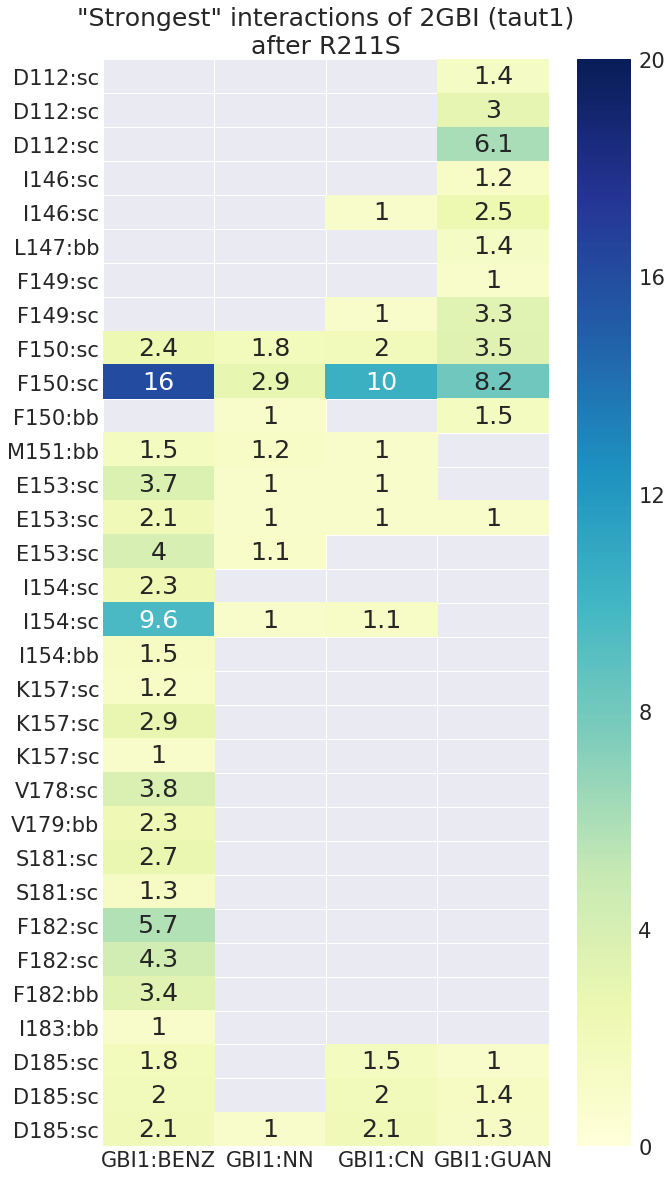

interaction range is from 0 to 20; verify if this is appropriate


In [20]:
# taut1 analysis after mutation
gidx_1 = nodes_1.index[nodes_1['resname'] == 'GBI1'].tolist()
s211_gbi1_edges = selectionInts(nodes_1, edges_1, gidx_1,rawNum=500)
plotHeatInts(nodes_1,s211_gbi1_edges,minHeat=0,maxHeat=20,colors="YlGnBu",size=(10,20),seltitle='2GBI (taut1)\nafter R211S')

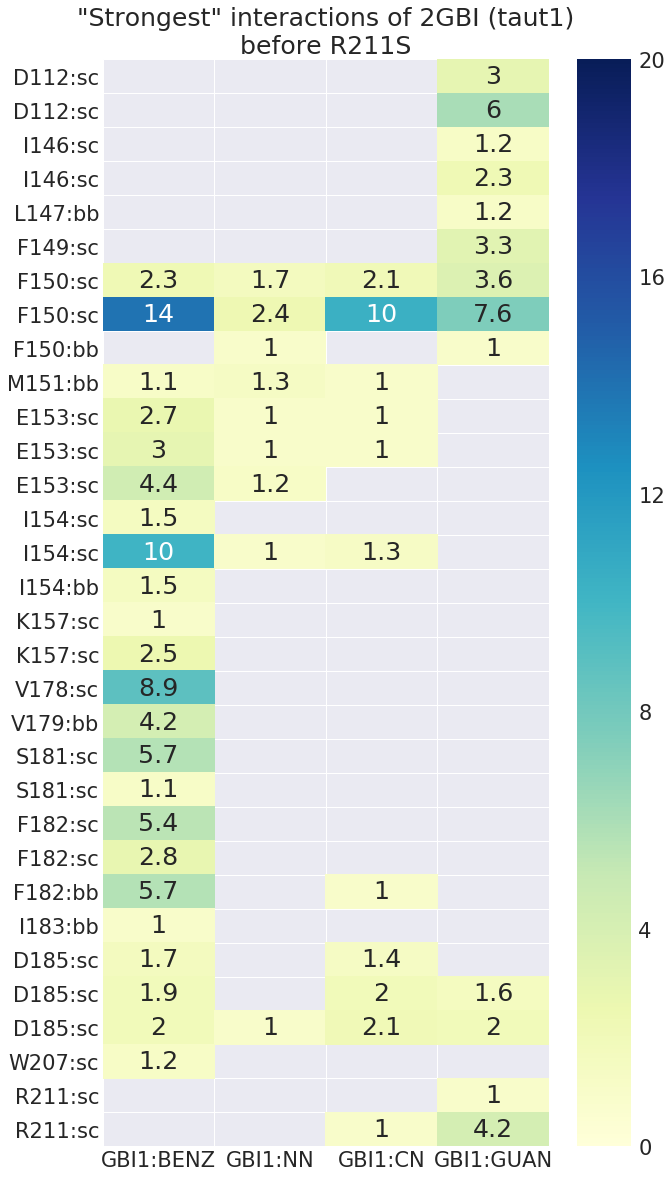

interaction range is from 0 to 20; verify if this is appropriate


In [21]:
# taut1 analysis before mutation
wt_gidx_1 = wt_nodes_1.index[wt_nodes_1['resname'] == 'GBI1'].tolist()
r211_gbi1_edges = selectionInts(wt_nodes_1, wt_edges_1, wt_gidx_1,rawNum=500)
plotHeatInts(wt_nodes_1,r211_gbi1_edges,minHeat=0,maxHeat=20,colors="YlGnBu",size=(10,20),seltitle='2GBI (taut1)\nbefore R211S')

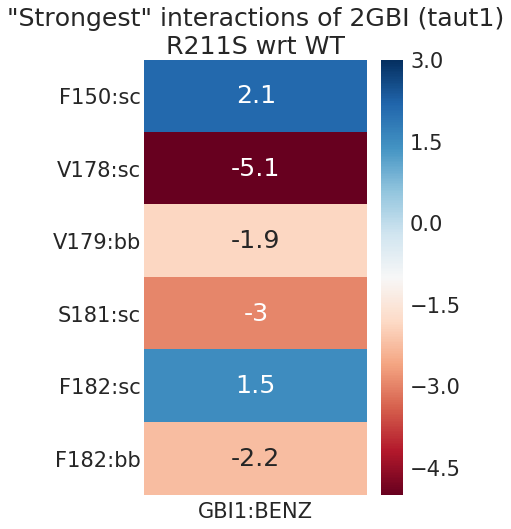

interaction range is from -5 to 3; verify if this is appropriate


In [25]:
# taut1 analysis (after-before) mutation
diff_gidx_1 = diff_nodes_1.index[diff_nodes_1['resname'] == 'GBI1'].tolist()
diff_gbi1_edges = selectionInts(diff_nodes_1, diff_edges_1, diff_gidx_1,rawNum=10)
plotHeatInts(diff_nodes_1,diff_gbi1_edges,minHeat=-5,maxHeat=3,colors="RdBu",size=(5,8),seltitle='2GBI (taut1)\nR211S wrt WT')

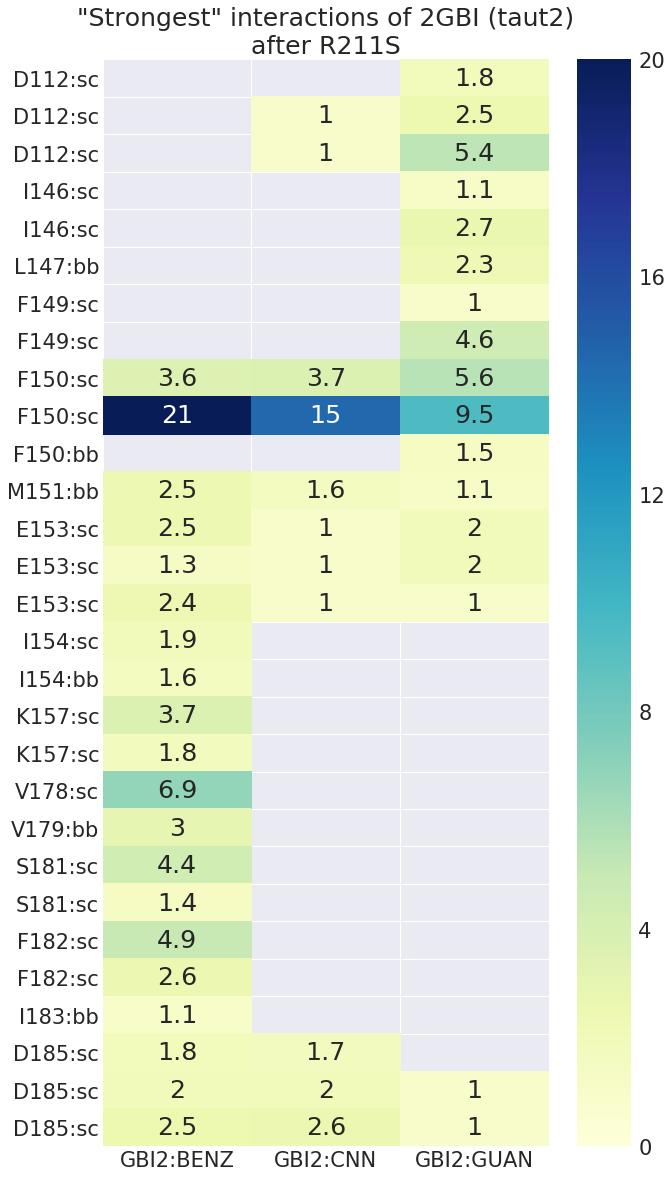

interaction range is from 0 to 20; verify if this is appropriate


In [26]:
# taut2 analysis after mutation
gidx_2 = nodes_2.index[nodes_2['resname'] == 'GBI2'].tolist()
s211_gbi2_edges = selectionInts(nodes_2, edges_2, gidx_2,rawNum=1000)
plotHeatInts(nodes_2,s211_gbi2_edges,minHeat=0,maxHeat=20,colors="YlGnBu",size=(10,20),seltitle='2GBI (taut2)\nafter R211S')

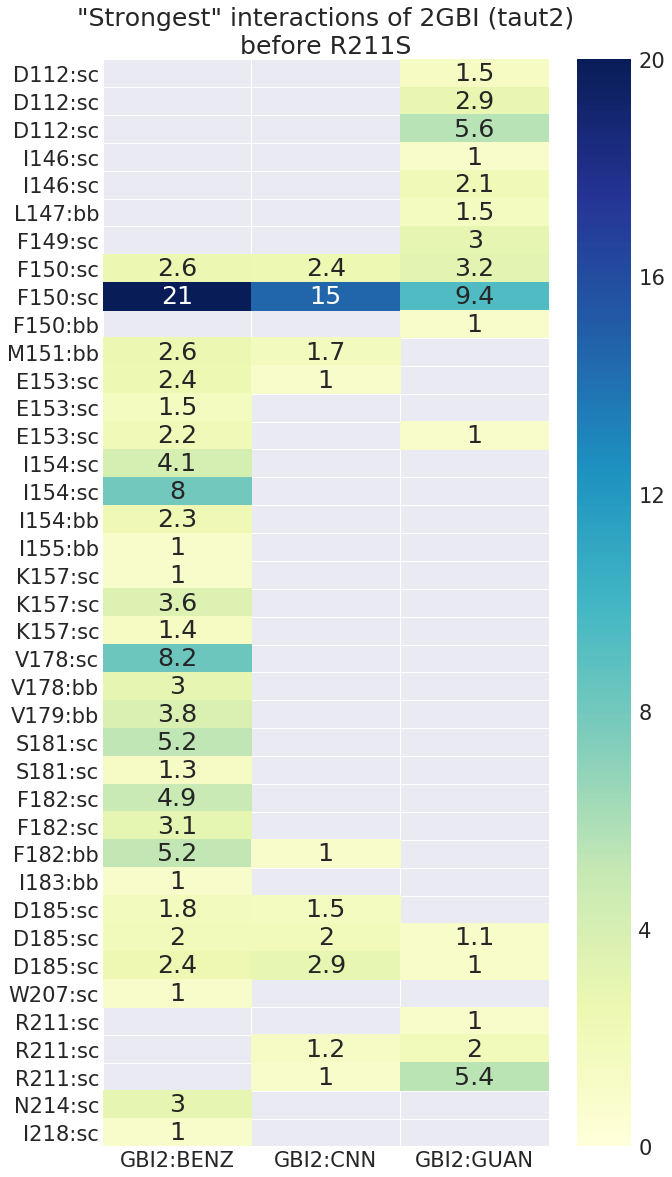

interaction range is from 0 to 20; verify if this is appropriate


In [27]:
# taut2 analysis before mutation
wt_gidx_2 = wt_nodes_2.index[wt_nodes_2['resname'] == 'GBI2'].tolist()
r211_gbi2_edges = selectionInts(wt_nodes_2, wt_edges_2, wt_gidx_2,rawNum=500)
plotHeatInts(wt_nodes_2,r211_gbi2_edges,minHeat=0,maxHeat=20,colors="YlGnBu",size=(10,20),seltitle='2GBI (taut2)\nbefore R211S')

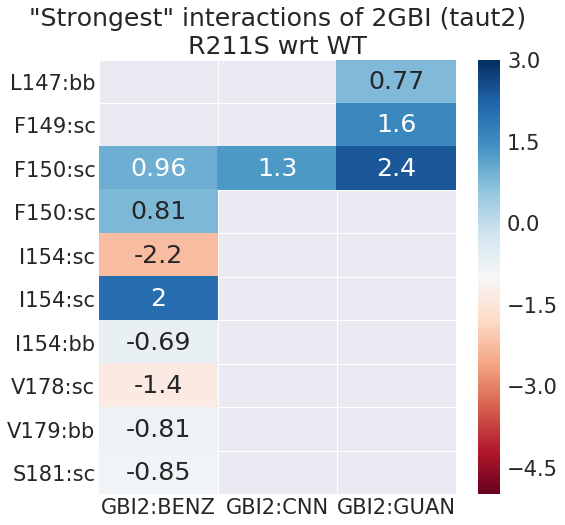

interaction range is from -5 to 3; verify if this is appropriate


In [28]:
# taut2 analysis (after-before) mutation
diff_gidx_2 = diff_nodes_2.index[diff_nodes_2['resname'] == 'GBI2'].tolist()
diff_gbi2_edges = selectionInts(diff_nodes_2, diff_edges_2, diff_gidx_2,rawNum=20)
plotHeatInts(diff_nodes_2,diff_gbi2_edges,minHeat=-5,maxHeat=3,colors="RdBu",size=(8,8),seltitle='2GBI (taut2)\nR211S wrt WT')

## Analysis 5: Interactions involving D112, D185

In [ ]:
selNodes_112 = getResidInfo(112, nodes_2, resExcludes=['WAT'])
selInds_112 = selNodes_112.index.tolist()
print(selInds_112)
selNodes_112

In [ ]:
selectionInts(nodes_1, edges_1, selInds_112)
#seltitle='D112\n(with taut1, after R211S)',maxvalue=10)

In [ ]:
selNodes_185 = getResidInfo(185, nodes_2, resExcludes=['WAT'])
selInds_185 = selNodes_185.index.tolist()
selectionInts(nodes_1, edges_1, selInds_185)
#seltitle='D185\n(with taut1, after R211S)',maxvalue=10)

## Troubleshooting

In [ ]:
for i, (index, row) in enumerate(diff_edges_1.iterrows()):
    print('\n ',i,row['node_i'],row['node_j'])
    print(idxToResid(row['node_i'], diff_nodes_1), idxToResid(row['node_j'], diff_nodes_1))

In [ ]:
edges_1[(edges_1.attribute == 'STER') & (edges_1.weight == 1865)]

In [ ]:
wt_edges_1[(wt_edges_1.attribute == 'HBOND') & (wt_edges_1.weight == 7) & (wt_edges_1.node_i == 413)]